In [2]:
N = 2500  # number_of_columns_to_selected_in_termDocumentMatrix
target = 'toxic'

In [3]:
import textmining
import nltk
import string
import numpy as np
from textblob import TextBlob
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.feature_selection import SelectFromModel

In [4]:
data = pd.read_csv("./Dataset/train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
data = data.loc[:, 'id':'identity_hate']
d1 = data.loc[data[target] == 1]
d2 = data.loc[data[target] == 0]
d1.shape
d2.shape[0]
d3 = d1.append(d2[0:d1.shape[0]])
d3.shape
d3.groupby(target).size()
d3 = d3.sort_index()

data = d3.copy()
del([d1,d2,d3])

In [7]:
data.index = range(0, data.shape[0])

In [8]:
id_column = data[['id']]
id_column.shape

(30588, 1)

In [9]:
data.groupby(target).size()

toxic
0    15294
1    15294
dtype: int64

# Pre-processing

In [10]:
stopwd = set(stopwords.words("english"))
punctuations = set(string.punctuation)

In [11]:
def clean(doc):
    stopwd_free = " ".join([i for i in doc.lower().split() if i not in stopwd])
    punc_free = "".join(i for i in stopwd_free if i not in punctuations)
    num_free = "".join(i for i in punc_free if not i.isdigit())
    return num_free

In [12]:
data_corpus = [clean(data.iloc[i,1]) for i in range(0, data.shape[0])]

In [13]:
data['comment_text'] = data_corpus

In [14]:
vectorizer = CountVectorizer(min_df=2, max_features=N)
vec = vectorizer.fit(data['comment_text'])

In [15]:
X = vec.transform(data['comment_text'])
X.shape

(30588, 2500)

In [16]:
train_tdm_all_features = vec.get_feature_names()           
len(train_tdm_all_features)

2500

In [17]:
df_tdm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [18]:
df_tdm[target] = data[target]
df_tdm[target] = np.where(df_tdm[target] == 0.0, 0, 1)

In [19]:
df_tdm['id'] = id_column
df_tdm.head()

,ability,able,about,above,absolute,absolutely,abuse,abusing,abusive,academic,...,youi,young,your,youre,yours,yourself,yourselfgo,youtube,zero,toxic
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Splitting into train and test data

In [20]:
training_data = df_tdm.sample(n= int(0.8*(df_tdm.shape[0])), random_state=7)
training_data.head()

,ability,able,about,above,absolute,absolutely,abuse,abusing,abusive,academic,...,youi,young,your,youre,yours,yourself,yourselfgo,youtube,zero,toxic
24390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
17375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7545,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2525,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
index_of_training_data = training_data.index
index_of_testing_data = [index for index in df_tdm.index if index not in index_of_training_data]
test_data = df_tdm.loc[index_of_testing_data]
test_data.head()

,ability,able,about,above,absolute,absolutely,abuse,abusing,abusive,academic,...,youi,young,your,youre,yours,yourself,yourselfgo,youtube,zero,toxic
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### Checking Data bias

In [22]:
df_tdm.groupby([target]).size()

toxic
0    15294
1    15294
dtype: int64

In [23]:
training_data.groupby([target]).size()

toxic
0    12230
1    12240
dtype: int64

In [24]:
test_data.groupby([target]).size()

toxic
0    3064
1    3054
dtype: int64

# Creating Model

In [25]:
predictors = [x for x in df_tdm.columns if x not in [target, 'id']]
len(predictors)

2499

In [26]:
xgb_model01 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=1000, silent=False, 
                            objective='binary:logistic', n_jobs=-1, gamma=0, min_child_weight=1, 
                            subsample=0.8, colsample_bytree=0.8, seed=5)

In [27]:
xgb_params = xgb_model01.get_xgb_params()
xgtrain = xgb.DMatrix(pd.DataFrame(training_data[predictors]), label=training_data[target].values)
cvresult = xgb.cv(params=xgb_params, dtrain=xgtrain, num_boost_round=xgb_model01.get_params()['n_estimators'], nfold=5, 
                  stratified=False, folds=None, metrics='auc', obj=None, feval=None, 
                  maximize=False, early_stopping_rounds=50, verbose_eval=True)
xgb_model01.set_params(n_estimators=cvresult.shape[0])   

#Fit the xgb_model01 algorithm on the data
xgb_model01.fit(X=training_data[predictors], 
        y=training_data[target], 
        eval_metric='auc')


[0]	train-auc:0.682152+0.00830047	test-auc:0.678945+0.0111748
[1]	train-auc:0.740557+0.00376963	test-auc:0.738728+0.0057936
[2]	train-auc:0.758784+0.00465061	test-auc:0.755492+0.00539646
[3]	train-auc:0.772796+0.00430315	test-auc:0.769321+0.00507684
[4]	train-auc:0.781994+0.00738079	test-auc:0.779509+0.00989044
[5]	train-auc:0.789166+0.00915195	test-auc:0.785387+0.0103884
[6]	train-auc:0.795644+0.00630568	test-auc:0.792713+0.00684426
[7]	train-auc:0.800117+0.00567807	test-auc:0.796862+0.00470148
[8]	train-auc:0.801158+0.00471431	test-auc:0.798402+0.00421785
[9]	train-auc:0.80498+0.00489719	test-auc:0.801512+0.00283616
[10]	train-auc:0.810286+0.00364691	test-auc:0.806858+0.00281309
[11]	train-auc:0.814461+0.00379034	test-auc:0.810554+0.00322163
[12]	train-auc:0.817862+0.00296907	test-auc:0.814011+0.00465842
[13]	train-auc:0.821708+0.00535636	test-auc:0.817754+0.00695394
[14]	train-auc:0.82666+0.00460668	test-auc:0.821904+0.00679086
[15]	train-auc:0.83242+0.00192134	test-auc:0.827263+0.0

[128]	train-auc:0.93819+0.000347013	test-auc:0.921677+0.00485413
[129]	train-auc:0.938433+0.000326242	test-auc:0.921942+0.00486581
[130]	train-auc:0.93872+0.000317553	test-auc:0.922165+0.00479551
[131]	train-auc:0.939054+0.000461653	test-auc:0.922432+0.00466762
[132]	train-auc:0.939355+0.000415561	test-auc:0.922497+0.00481866
[133]	train-auc:0.939604+0.000468234	test-auc:0.92273+0.00471944
[134]	train-auc:0.939925+0.000509239	test-auc:0.922952+0.00460753
[135]	train-auc:0.940163+0.000545269	test-auc:0.923149+0.00460791
[136]	train-auc:0.940344+0.000574939	test-auc:0.92331+0.00454528
[137]	train-auc:0.940592+0.000615596	test-auc:0.923601+0.00439083
[138]	train-auc:0.940902+0.000618628	test-auc:0.923739+0.00445231
[139]	train-auc:0.941183+0.000629636	test-auc:0.924032+0.00460019
[140]	train-auc:0.941502+0.000619965	test-auc:0.924306+0.00456672
[141]	train-auc:0.941763+0.000605063	test-auc:0.924469+0.00472251
[142]	train-auc:0.941932+0.000564021	test-auc:0.924557+0.0046865
[143]	train-auc

[253]	train-auc:0.959794+0.000409641	test-auc:0.939034+0.00399139
[254]	train-auc:0.959876+0.000454668	test-auc:0.939112+0.00394196
[255]	train-auc:0.960017+0.000421637	test-auc:0.939215+0.00402278
[256]	train-auc:0.960104+0.000422412	test-auc:0.939329+0.00401901
[257]	train-auc:0.960267+0.000400267	test-auc:0.939437+0.00404775
[258]	train-auc:0.960345+0.000397246	test-auc:0.9395+0.00407659
[259]	train-auc:0.960456+0.000442667	test-auc:0.939603+0.00414126
[260]	train-auc:0.960556+0.000423517	test-auc:0.939645+0.00413311
[261]	train-auc:0.960622+0.000457162	test-auc:0.939686+0.00411269
[262]	train-auc:0.960741+0.000437857	test-auc:0.939713+0.00411939
[263]	train-auc:0.960841+0.000447504	test-auc:0.939789+0.00414435
[264]	train-auc:0.960933+0.000464462	test-auc:0.939888+0.00411831
[265]	train-auc:0.961011+0.000499335	test-auc:0.939948+0.00410336
[266]	train-auc:0.961087+0.000486028	test-auc:0.940019+0.00411941
[267]	train-auc:0.961184+0.000484856	test-auc:0.940094+0.0041318
[268]	train-a

[379]	train-auc:0.968938+0.000477614	test-auc:0.946325+0.00376309
[380]	train-auc:0.968998+0.00049283	test-auc:0.946335+0.00376894
[381]	train-auc:0.969063+0.000482411	test-auc:0.946428+0.00376846
[382]	train-auc:0.969114+0.000469824	test-auc:0.946514+0.00385641
[383]	train-auc:0.969159+0.000461786	test-auc:0.946573+0.00385531
[384]	train-auc:0.969241+0.000488463	test-auc:0.946649+0.00385599
[385]	train-auc:0.969281+0.00049909	test-auc:0.9467+0.00387423
[386]	train-auc:0.96933+0.000495588	test-auc:0.946741+0.00390772
[387]	train-auc:0.969378+0.000488124	test-auc:0.946788+0.00392536
[388]	train-auc:0.969418+0.000494027	test-auc:0.946806+0.00396575
[389]	train-auc:0.969463+0.000503396	test-auc:0.94685+0.00393173
[390]	train-auc:0.969501+0.000492343	test-auc:0.946874+0.00394207
[391]	train-auc:0.96956+0.00050427	test-auc:0.946901+0.00395034
[392]	train-auc:0.969604+0.000476147	test-auc:0.946959+0.00393266
[393]	train-auc:0.969643+0.000452955	test-auc:0.946985+0.00390341
[394]	train-auc:0.

[505]	train-auc:0.974069+0.000226567	test-auc:0.949962+0.00364757
[506]	train-auc:0.974093+0.000222498	test-auc:0.949989+0.0036523
[507]	train-auc:0.974116+0.000213687	test-auc:0.949995+0.00365934
[508]	train-auc:0.974167+0.000212911	test-auc:0.950016+0.00365677
[509]	train-auc:0.974207+0.000220832	test-auc:0.950035+0.00365508
[510]	train-auc:0.974245+0.00022376	test-auc:0.950034+0.00363358
[511]	train-auc:0.97427+0.000221868	test-auc:0.950063+0.00362607
[512]	train-auc:0.974315+0.000216361	test-auc:0.950108+0.00366116
[513]	train-auc:0.97433+0.000232299	test-auc:0.950144+0.00368479
[514]	train-auc:0.974353+0.000227796	test-auc:0.950153+0.00366595
[515]	train-auc:0.97439+0.000234492	test-auc:0.95016+0.00368897
[516]	train-auc:0.974415+0.000240802	test-auc:0.950131+0.00373951
[517]	train-auc:0.974431+0.000229732	test-auc:0.950188+0.00375691
[518]	train-auc:0.974466+0.000234194	test-auc:0.950198+0.003748
[519]	train-auc:0.974499+0.000229304	test-auc:0.950227+0.00375796
[520]	train-auc:0.

[630]	train-auc:0.97747+0.000288708	test-auc:0.952091+0.00335728
[631]	train-auc:0.977491+0.000295473	test-auc:0.952091+0.00338159
[632]	train-auc:0.977516+0.000285437	test-auc:0.952112+0.00337569
[633]	train-auc:0.977538+0.000276893	test-auc:0.952132+0.0033751
[634]	train-auc:0.977572+0.000268673	test-auc:0.952132+0.00337666
[635]	train-auc:0.977597+0.000276591	test-auc:0.952131+0.00337073
[636]	train-auc:0.977612+0.000276227	test-auc:0.952162+0.0033617
[637]	train-auc:0.977635+0.000271913	test-auc:0.952154+0.00335523
[638]	train-auc:0.97766+0.000271454	test-auc:0.952178+0.00335798
[639]	train-auc:0.97768+0.000269847	test-auc:0.952182+0.00334127
[640]	train-auc:0.977704+0.000271232	test-auc:0.95222+0.00331972
[641]	train-auc:0.977723+0.000280288	test-auc:0.952241+0.00332959
[642]	train-auc:0.977741+0.00028262	test-auc:0.952262+0.00333147
[643]	train-auc:0.977766+0.000280207	test-auc:0.95228+0.00330999
[644]	train-auc:0.977783+0.000281028	test-auc:0.952275+0.00330734
[645]	train-auc:0.

[755]	train-auc:0.979804+0.000195856	test-auc:0.95338+0.00335833
[756]	train-auc:0.979823+0.000185964	test-auc:0.953387+0.00333932
[757]	train-auc:0.97984+0.000189655	test-auc:0.953368+0.00331512
[758]	train-auc:0.979857+0.00019401	test-auc:0.953386+0.00331054
[759]	train-auc:0.979877+0.000190125	test-auc:0.953388+0.00331656
[760]	train-auc:0.979893+0.000195363	test-auc:0.95339+0.00330646
[761]	train-auc:0.979896+0.000195605	test-auc:0.953393+0.00330256
[762]	train-auc:0.979911+0.000202048	test-auc:0.953401+0.00331864
[763]	train-auc:0.979932+0.000196822	test-auc:0.953394+0.00330454
[764]	train-auc:0.979942+0.000198214	test-auc:0.953376+0.00330908
[765]	train-auc:0.97996+0.000202067	test-auc:0.953391+0.00332056
[766]	train-auc:0.979976+0.000197348	test-auc:0.953407+0.00331625
[767]	train-auc:0.980003+0.00019792	test-auc:0.953415+0.00332142
[768]	train-auc:0.98002+0.000173542	test-auc:0.953416+0.00334144
[769]	train-auc:0.980048+0.000173121	test-auc:0.953412+0.00335626
[770]	train-auc:0

[880]	train-auc:0.981645+0.000116316	test-auc:0.954+0.00350065
[881]	train-auc:0.981648+0.000118584	test-auc:0.953999+0.00350897
[882]	train-auc:0.981665+0.000123477	test-auc:0.95401+0.00350484
[883]	train-auc:0.981679+0.000129488	test-auc:0.954001+0.00350419
[884]	train-auc:0.98169+0.000135473	test-auc:0.954027+0.00351831
[885]	train-auc:0.981707+0.000139936	test-auc:0.954032+0.00354472
[886]	train-auc:0.981726+0.0001417	test-auc:0.954048+0.00355372
[887]	train-auc:0.981743+0.000145123	test-auc:0.954056+0.00355291
[888]	train-auc:0.981755+0.000142905	test-auc:0.954052+0.0035699
[889]	train-auc:0.981768+0.000143514	test-auc:0.954052+0.00357137
[890]	train-auc:0.981788+0.000142941	test-auc:0.954049+0.00356677
[891]	train-auc:0.981807+0.000144907	test-auc:0.954061+0.00356162
[892]	train-auc:0.981825+0.000149074	test-auc:0.954049+0.00357176
[893]	train-auc:0.981839+0.000143145	test-auc:0.954069+0.00357795
[894]	train-auc:0.981854+0.000143102	test-auc:0.954063+0.00359344
[895]	train-auc:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=5, silent=False, subsample=0.8)

###### Feature Importance Graph

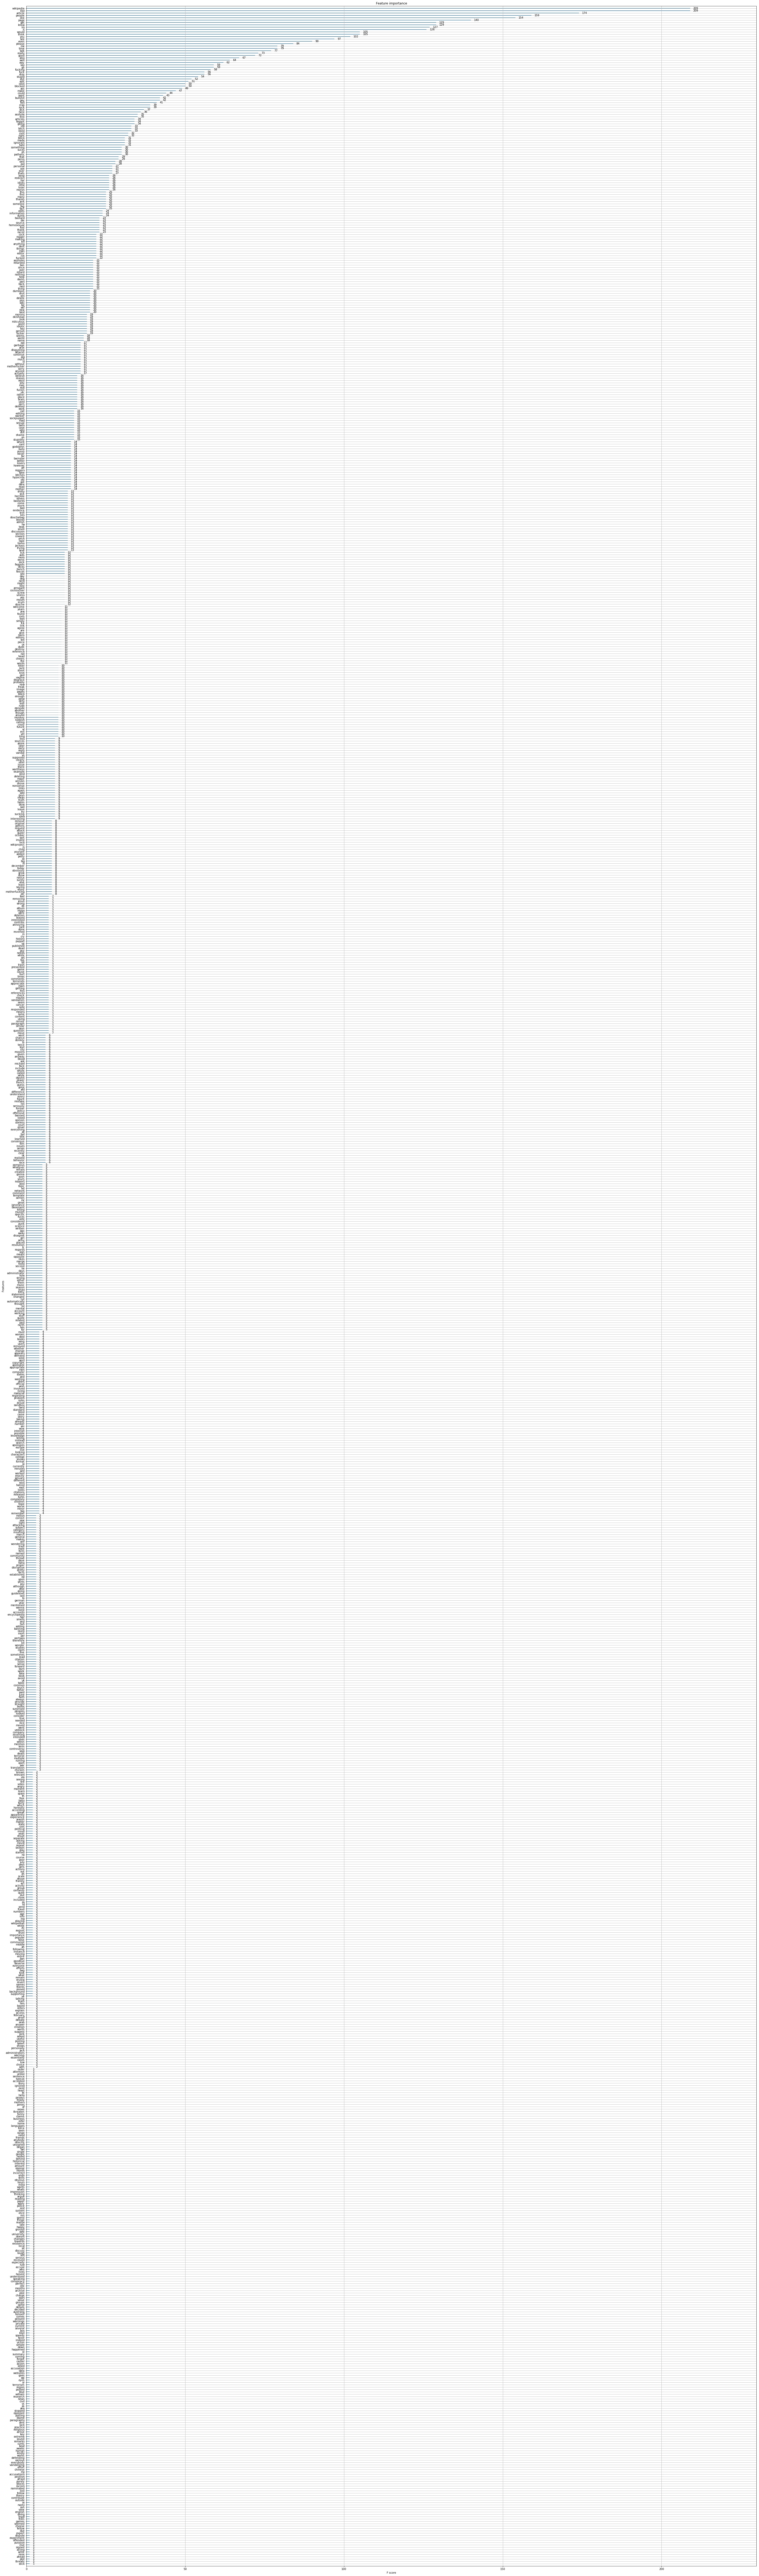

In [33]:
rcParams['figure.figsize'] = 50,180
xgb.plot_importance(xgb_model01.get_booster())

In [34]:
#Predict training set:
train_predictions = xgb_model01.predict(training_data[predictors])
train_predprob = xgb_model01.predict_proba(training_data[predictors])[:, 1]  

#Print model report:
acc = float(accuracy_score(training_data[target], train_predictions)) * 100
AUC = float(roc_auc_score(training_data[target], train_predprob, average='weighted')) * 100
f1 = float(f1_score(training_data[target], train_predictions, average='weighted')) * 100

print("\nModel Report (TRAIN) :\n")
print("Accurary : %.6g" % acc)
print("AUC Score : %.6g" % AUC)
print("F1 Score : %.6g" % f1)

# Predicting on test data:
test_predictions = xgb_model01.predict(test_data[predictors])
test_predprob = xgb_model01.predict_proba(test_data[predictors])[:, 1]  

#Print model report:
acc = float(accuracy_score(test_data[target], test_predictions)) * 100
AUC = float(roc_auc_score(test_data[target], test_predprob, average='weighted')) * 100
f1 = float(f1_score(test_data[target], test_predictions, average='weighted')) * 100

print("\nModel Report (TEST) : \n")
print("Accurary : %.6g" % acc)
print("AUC Score : %.6g" % AUC)
print("F1 Score : %.6g" % f1)

C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report (TRAIN) :

Accurary : 92.4642
AUC Score : 98.2263
F1 Score : 92.4515


C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report (TEST) : 

Accurary : 88.4766
AUC Score : 95.5961
F1 Score : 88.4535


# Saving Model

In [62]:
path = './model pickle/'
filename = path + "XGBClassifier_equalData_" + target + "_" + str(N) + "_F1_Score" + str(format(f1, '.6g'))
joblib.dump(xgb_model01, filename)

['./model pickle/XGBClassifier_equalData_toxic_2500_F1_Score88.4535']

# Loading Model

In [32]:
# path = './model pickle/'
# filename = path + 'XGBClassifier_equalData_toxic_3000_F1_Score87.6949'
# xgb_model01 = joblib.load(filename)

# Probability prediction for test.csv provided by kaggle

In [36]:
testCSV = pd.read_csv('./Dataset/test.csv')

In [37]:
testCSV.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [38]:
testCSV.shape

(153164, 2)

### Pre-processing

In [39]:
data_corpus_testCSV = [clean(testCSV.iloc[i,1]) for i in range(0, testCSV.shape[0])]

In [40]:
testCSV['comment_text'] = data_corpus_testCSV

In [41]:
testCSV.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,rfc title fine is imo
2,00013b17ad220c46,sources zawe ashton lapland —
3,00017563c3f7919a,if look back source information updated correc...
4,00017695ad8997eb,anonymously edit articles all


In [45]:
vectorizer = CountVectorizer(min_df=2, max_features=N, vocabulary=train_tdm_all_features) 
vec = vectorizer.fit(testCSV['comment_text'])

In [46]:
X = vec.transform(testCSV['comment_text'])
X.shape

(153164, 2500)

In [47]:
df_tdm_testCSV = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [48]:
df_tdm_testCSV.id = testCSV.id

In [49]:
predictors_for_testCSV = [x for x in df_tdm_testCSV.columns if x not in [target, 'id']]

In [50]:
df_tdm_testCSV[predictors_for_testCSV].shape

(153164, 2499)

In [52]:
df_tdm_testCSV.head()

,ability,able,about,above,absolute,absolutely,abuse,abusing,abusive,academic,...,youfuck,youi,young,your,youre,yours,yourself,yourselfgo,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
prediction_final = xgb_model01.predict_proba((df_tdm_testCSV[predictors_for_testCSV]))[:,1]

In [56]:
final_submission = testCSV.copy()
final_submission = final_submission.drop('comment_text', axis=1)

In [57]:
final_submission.head()

,id
0,00001cee341fdb12
1,0000247867823ef7
2,00013b17ad220c46
3,00017563c3f7919a
4,00017695ad8997eb


In [58]:
final_submission[target] = prediction_final

In [61]:
final_submission.head(5)

,id,toxic
0,00001cee341fdb12,0.999996
1,0000247867823ef7,0.166511
2,00013b17ad220c46,0.266785
3,00017563c3f7919a,0.071220
4,00017695ad8997eb,0.327090


###### Saving csv file on the disk

In [60]:
final_submission.to_csv('./sample_submission.csv')